In [1]:
from typing import List, Optional
import urllib.request
from tqdm import tqdm
from pathlib import Path
import requests
import torch
import math
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import random
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
import pandas as pd
import sklearn.metrics
import seaborn as sb

import torch.nn as nn


torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    numpy.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(0)


In [2]:
import utils

In [3]:
import importlib
importlib.reload(utils)

<module 'utils' from '/Users/moritzduck/Desktop/ETH/4_FS2023/Research_IXAI/collaiborate/collaiborate/utils.py'>

In [4]:
# given the random seeds and arguments are the same, this "should" give the same train/test split..
# TODO: find better way to persist train/test split

utils.download_quickdraw_dataset(root="../data/npy", class_names = ['airplane', 'apple', 'wine bottle', 'car', 'mouth', 'pineapple', 'umbrella', 'pear', 'moustache', 'smiley face'] + ['train', 'mosquito', 'bee', 'dragon', 'piano'])
dataset = utils.QuickDrawDataset(root = "../data/npy", max_items_per_class=100000)

train_ds, val_ds = dataset.split(0.2)
validation_dataloader = DataLoader(val_ds, batch_size=1, shuffle=False)

100%|█████████████████████████████████████████| 15/15 [00:00<00:00, 9305.51it/s]


Loading 100000 examples for each class from the Quickdraw Dataset...


100%|███████████████████████████████████████████| 15/15 [00:03<00:00,  3.87it/s]


In [5]:
model = nn.Sequential(
   nn.Conv2d(1, 16, 3, padding='same'),
   nn.ReLU(),
   nn.MaxPool2d(2),
   nn.Conv2d(16, 32, 3, padding='same'),
   nn.ReLU(),
   nn.MaxPool2d(2),
   nn.Conv2d(32, 32, 3, padding='same'),
   nn.ReLU(),
   nn.MaxPool2d(2),
   nn.Flatten(),
   nn.Linear(288, 128),
   nn.ReLU(),
   nn.Linear(128, len(dataset.classes)),
)

In [6]:
checkpoint = torch.load('./model_lessCapacity.pth',  map_location=torch.device('cpu'))
model.load_state_dict(checkpoint)

model.eval()

Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Linear(in_features=288, out_features=128, bias=True)
  (11): ReLU()
  (12): Linear(in_features=128, out_features=15, bias=True)
)

In [7]:
stats = [{"idx": i, "label": dataset.classes[i], "count": 0, "correct": 0} for i in range(15)]

for i, batch in enumerate(validation_dataloader, 0):
    x, y, idx = batch
    logits = model(x)
    y_hat = np.argmax(logits.detach().numpy())
    
    class_idx = y.item()
    
    stats[class_idx]["count"] += 1
    if(y.item() == y_hat):
        stats[class_idx]["correct"] += 1
        

In [8]:
df = pd.DataFrame.from_dict(stats).set_index('idx')
df['accuracy'] = df['correct']/df['count']


In [9]:
## manual mapping could be done better...

df['category'] = ['convergent' for i in range(15)]

df.at[2, 'category'] = 'divergent'
df.at[4, 'category'] = 'divergent'
df.at[5, 'category'] = 'divergent'
df.at[9, 'category'] = 'divergent'
df.at[12, 'category'] = 'divergent'


In [10]:
df[df.category == 'convergent'].accuracy.mean()

0.9380084564409474

In [11]:
df

,label,count,correct,accuracy,category
idx,,,,,
0,airplane,19946,18126,0.908754,convergent
1,apple,19961,18964,0.950053,convergent
2,bee,19941,18041,0.904719,divergent
3,car,20118,18934,0.941147,convergent
4,dragon,19811,16466,0.831154,divergent
5,mosquito,20247,16779,0.828715,divergent
6,moustache,20114,18099,0.899821,convergent
7,mouth,20240,18619,0.919911,convergent
8,pear,20019,18181,0.908187,convergent


In [ ]:
indices = [i*100000 for i in range(13)]
indices = [i + j for j in range(30) for i in indices]
for idx in indices:
    plt.figure()
    plt.imshow(dataset[idx][0].reshape(28,28,1), cmap='Greys')
    #plt.title(dataset.classes[dataset[idx][1]])
    plt.axis('off')
    plt.savefig(dataset.classes[dataset[idx][1]] +  str(idx) + '.png', bbox_inches='tight')

In [747]:
idx = 300000

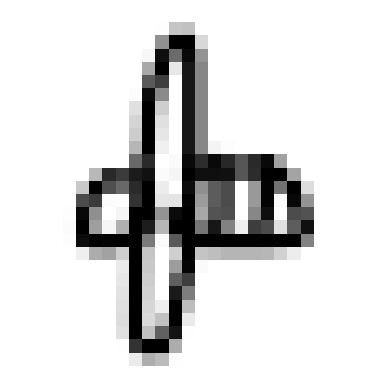

In [1257]:
idx += +1
plt.figure()
plt.imshow(dataset[idx][0].reshape(28,28,1), cmap='Greys')
#plt.title(dataset.classes[dataset[idx][1]])
plt.axis('off')
plt.show()



## Confusion Matrix

In [12]:
columns = ['index', 'y', 'y_hat', 'logits', 'probs']
predictions = []

for i, batch in tqdm(enumerate(validation_dataloader, 0)):
    x, y, idx = batch
    logits = model(x)

    logits = logits.detach().numpy()
    probs = np.exp(logits)/np.exp(logits).sum()

    y_hat = np.argmax(logits)
    
    class_idx = y.item()
    
    predictions.append([idx, y, y_hat, logits, probs])
        

300000it [03:23, 1470.65it/s]


In [13]:
df2 = pd.DataFrame(predictions, columns=columns)
df2.y = df2.y.apply(lambda x: x[0].item())

In [14]:
df2.y_hat

0         14
1          9
2          9
3         12
4         11
          ..
299995    14
299996    11
299997     3
299998    12
299999     4
Name: y_hat, Length: 300000, dtype: int64

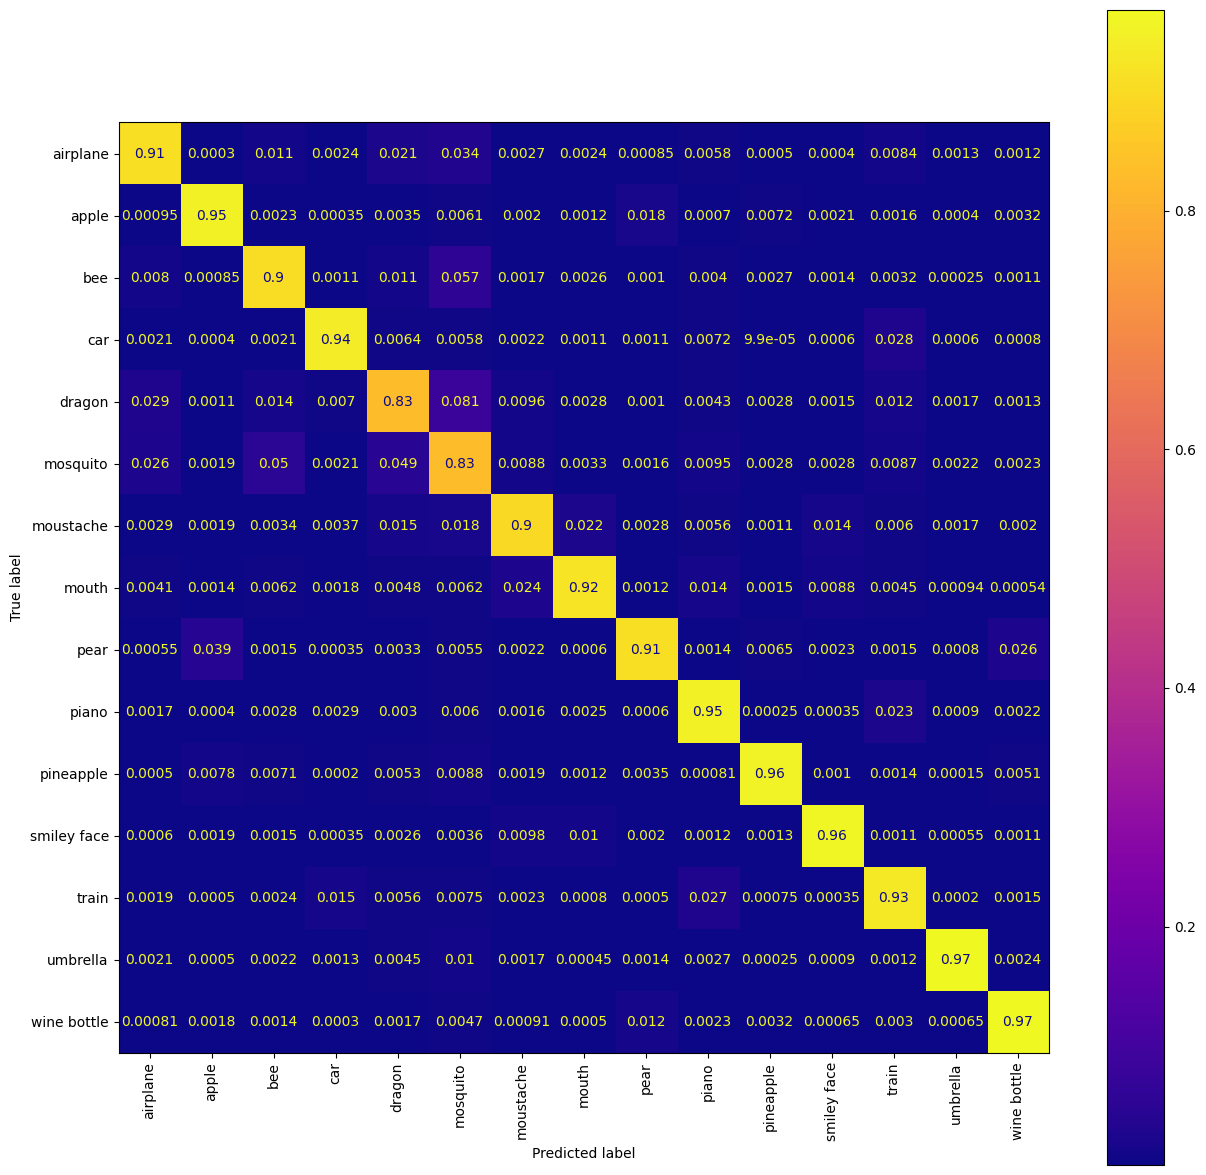

In [14]:
cm = sklearn.metrics.confusion_matrix(list(df2.y), list(df2.y_hat), normalize='true')
disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=dataset.classes)
fig, ax = plt.subplots(figsize=(15, 15))
disp.plot(xticks_rotation='vertical', ax=ax, cmap='plasma')

In [15]:
cm[:,4].sum()

0.9676287609843178

In [16]:
cm[4,:].sum()

1.0

## Metrics

In [17]:
metrics = sklearn.metrics.precision_recall_fscore_support(list(df2.y), list(df2.y_hat)
                                                         ,labels=range(len(dataset.classes)))


In [18]:
df3 = pd.DataFrame(np.array(metrics).T, columns=['precision', 'recall', 'fscore', 'support'])


In [19]:
df3['className'] = dataset.classes

In [20]:
df3

,precision,recall,fscore,support,className
0,0.917493,0.908754,0.913103,19946.0,airplane
1,0.941188,0.950053,0.945600,19961.0,apple
2,0.893340,0.904719,0.898993,19941.0,bee
3,0.961166,0.941147,0.951051,20118.0,car
4,0.857247,0.831154,0.843999,19811.0,dragon
5,0.768304,0.828715,0.797367,20247.0,mosquito
6,0.926443,0.899821,0.912938,20114.0,moustache
7,0.947243,0.919911,0.933377,20240.0,mouth
8,0.950094,0.908187,0.928668,20019.0,pear
9,0.916141,0.952259,0.933851,19962.0,piano


## ROC

In [21]:
one_hot = np.zeros((df2.y_hat.size, df2.y_hat.max() + 1))
one_hot[np.arange(df2.y_hat.size), df2.y_hat] = 1

In [22]:
logits_as_list = np.array(list(df2.logits.apply(lambda x: x[0])))

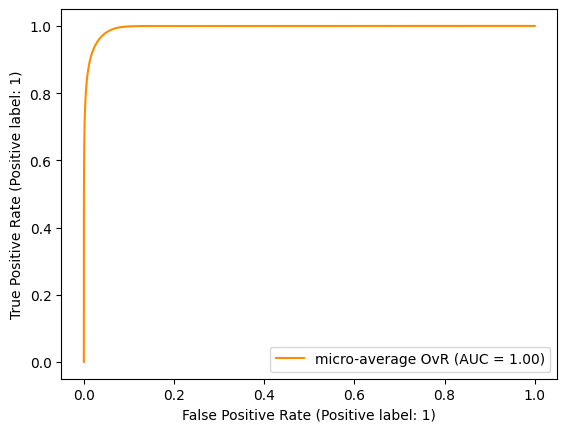

In [23]:
sklearn.metrics.RocCurveDisplay.from_predictions(
    one_hot.ravel(),
    logits_as_list.ravel(),
    name="micro-average OvR",
    color="darkorange",
)

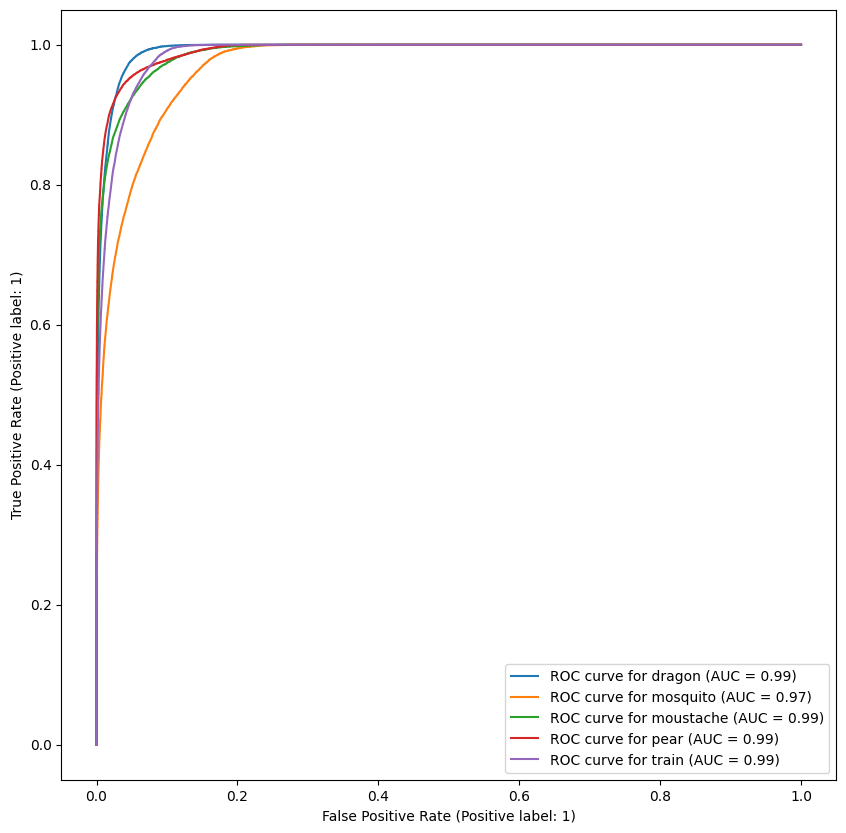

In [24]:
import itertools
fig, ax = plt.subplots(figsize=(10, 10))
# classes for which AUC is the worst
for class_id in [4,5,6,8,12]:
    sklearn.metrics.RocCurveDisplay.from_predictions(
        one_hot[:, class_id],
        logits_as_list[:, class_id],
        name=f"ROC curve for {dataset.classes[class_id]}",
        ax=ax,
    )

## Boxplot

In [25]:
df2['probs']

0         [[5.9235697e-07, 4.066088e-06, 1.0604693e-06, ...
1         [[1.4604352e-06, 2.8997862e-08, 1.5788268e-07,...
2         [[0.000104972336, 2.8398308e-05, 0.00073169864...
3         [[1.567037e-05, 3.1026346e-07, 1.7309346e-06, ...
4         [[4.6267734e-05, 3.7371515e-06, 4.7951096e-05,...
                                ...                        
299995    [[5.612542e-06, 3.7378354e-06, 1.3047197e-06, ...
299996    [[5.069335e-05, 4.2590007e-05, 7.73768e-06, 7....
299997    [[2.3089046e-07, 3.9080425e-10, 4.6303295e-08,...
299998    [[0.0002625319, 0.00021722009, 0.0003442158, 0...
299999    [[0.007379506, 1.775118e-06, 2.8607481e-05, 2....
Name: probs, Length: 300000, dtype: object

In [26]:
dfx = df2.join(pd.DataFrame(list(df2['probs'].apply(lambda x : x[0])), columns=dataset.classes))
dfx['y_class'] = dfx.y.apply(lambda x : dataset.classes[x])

In [27]:
dfx['pred_prob_for_true_class'] = dfx.apply(lambda x: x.probs[0][x.y], axis=1)

[Text(0.5, 0, 'Classes'), Text(0, 0.5, 'Predicted Probabilities')]

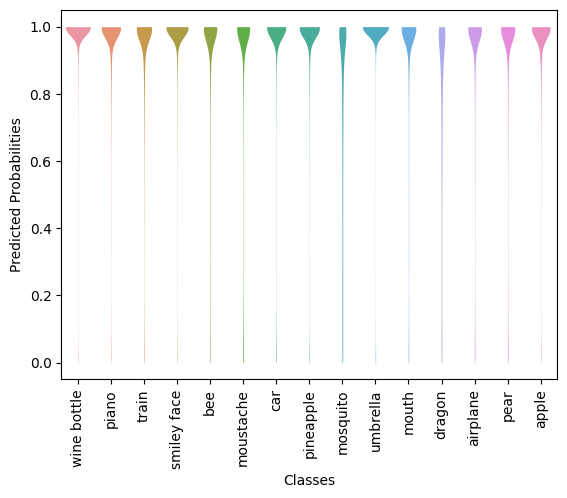

In [29]:
chart = sb.violinplot(
    x = 'y_class', 
    y = "pred_prob_for_true_class", 
    data = dfx, 
    inner="stick", 
    cut=0, 
    linewidth=0)
chart.set_xticklabels(chart.get_xticklabels(),rotation = 90)
chart.set(xlabel='Classes', ylabel='Predicted Probabilities')

[Text(0.5, 0, 'Classes'), Text(0, 0.5, 'Predicted Probabilities')]

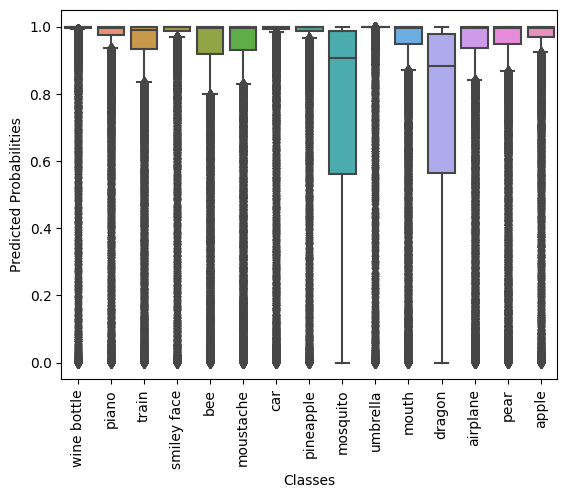

In [30]:
chart = sb.boxplot(
    x = 'y_class', 
    y = "pred_prob_for_true_class", 
    data = dfx)
chart.set_xticklabels(chart.get_xticklabels(),rotation = 90)
chart.set(xlabel='Classes', ylabel='Predicted Probabilities')

# Single Predictions

In [211]:
index = np.random.randint(0, len(dataset))

In [263]:
batch = dataset[index]
x, y = batch
x_batch = x.unsqueeze(dim=0)
logits = model(x_batch)

logits = logits.detach().numpy()
probs = np.exp(logits)/np.exp(logits).sum()
probs = probs[0]
y_hat = np.argmax(logits)
class_name = dataset.classes[y]


(-0.5, 27.5, 27.5, -0.5)

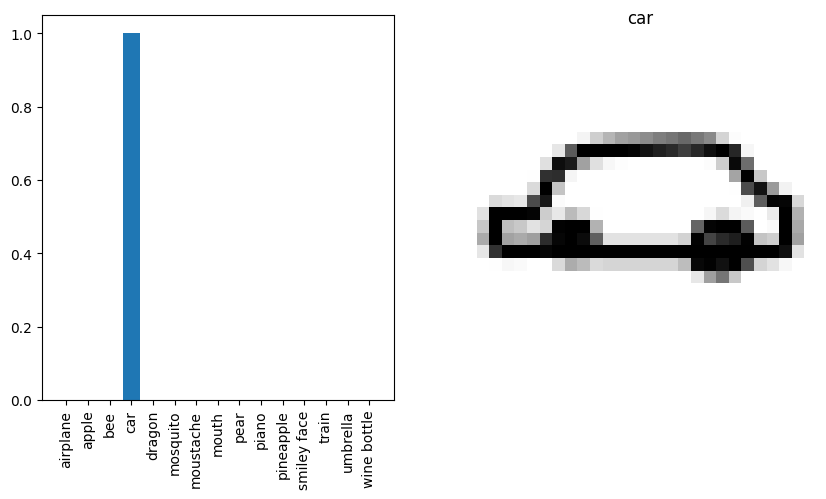

In [270]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.bar(range(len(probs)),probs, tick_label=dataset.classes)
ax1.set_xticklabels(dataset.classes, rotation=90)
plt.xticks()
ax2.imshow(x.reshape(28,28,1), cmap='Greys')
plt.title(dataset.classes[dataset[index][1]])
plt.axis('off')

In [63]:
def get_prediction(index):
    batch = dataset[index]
    x, y, idx = batch
    x_batch = x.unsqueeze(dim=0)
    logits = model(x_batch)

    logits = logits.detach().numpy()
    probs = np.exp(logits)/np.exp(logits).sum()
    probs = probs[0]
    y_hat = np.argmax(logits)
    class_name = dataset.classes[y]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.bar(range(len(probs)),probs, tick_label=dataset.classes)
    ax1.set_xticklabels(dataset.classes, rotation=90)
    ax1.set_title(index)
    plt.xticks()
    ax2.imshow(x.reshape(28,28,1), cmap='Greys')
    plt.title(dataset.classes[dataset[index][1]])
    plt.axis('off')

In [ ]:
get_prediction(np.random.randint(0, len(dataset)))

In [223]:
class_name

'car'

In [218]:
x.shape

torch.Size([1, 28, 28])

### Specific Analysis

In [47]:
completely_wrong = list(dfx[dfx.pred_prob_for_true_class < 0.01]['index'].apply(lambda x: x.item()))

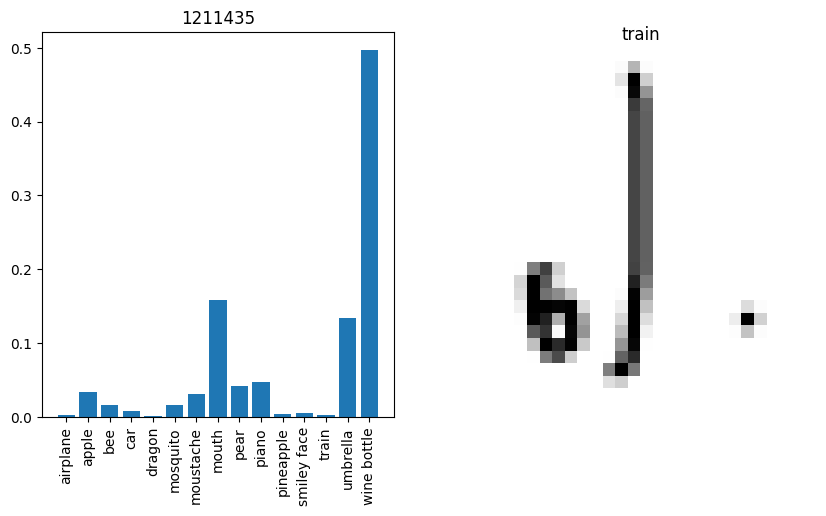

In [157]:
get_prediction(completely_wrong[np.random.randint(0,len(completely_wrong))])

## Correlation

In [182]:
corr = dfx[dataset.classes][dfx.pred_prob_for_true_class < 0.8].corr()
corr.style.background_gradient(cmap='coolwarm')


,airplane,apple,bee,car,dragon,mosquito,moustache,mouth,pear,piano,pineapple,smiley face,train,umbrella,wine bottle
airplane,1.000000,-0.127922,-0.065589,-0.066694,0.002366,-0.004953,-0.124483,-0.103546,-0.133453,-0.094434,-0.097866,-0.104371,-0.099888,-0.021491,-0.092735
apple,-0.127922,1.000000,-0.123404,-0.089349,-0.163488,-0.191071,-0.096150,-0.092394,0.337962,-0.108226,0.081841,-0.034504,-0.114345,-0.045040,-0.020198
bee,-0.065589,-0.123404,1.000000,-0.106961,-0.137677,0.153025,-0.160937,-0.108864,-0.147522,-0.119020,-0.035055,-0.099846,-0.154967,-0.062682,-0.108081
car,-0.066694,-0.089349,-0.106961,1.000000,-0.079623,-0.165154,-0.051511,-0.066687,-0.087834,-0.005506,-0.072233,-0.058930,0.209908,-0.013209,-0.073636
dragon,0.002366,-0.163488,-0.137677,-0.079623,1.000000,0.033236,-0.103765,-0.170750,-0.179000,-0.174126,-0.099339,-0.121221,-0.153307,-0.062211,-0.136277
mosquito,-0.004953,-0.191071,0.153025,-0.165154,0.033236,1.000000,-0.189222,-0.212864,-0.220648,-0.180808,-0.118231,-0.154703,-0.221060,-0.046632,-0.164627
moustache,-0.124483,-0.096150,-0.160937,-0.051511,-0.103765,-0.189222,1.000000,0.263181,-0.100711,-0.103527,-0.070275,0.143729,-0.109502,-0.003000,-0.077141
mouth,-0.103546,-0.092394,-0.108864,-0.066687,-0.170750,-0.212864,0.263181,1.000000,-0.104452,-0.003943,-0.065053,0.124822,-0.105033,-0.033617,-0.081935
pear,-0.133453,0.337962,-0.147522,-0.087834,-0.179000,-0.220648,-0.100711,-0.104452,1.000000,-0.112414,0.011597,-0.040718,-0.126121,-0.027508,0.242766
piano,-0.094434,-0.108226,-0.119020,-0.005506,-0.174126,-0.180808,-0.103527,-0.003943,-0.112414,1.000000,-0.081575,-0.076305,0.165587,-0.021350,-0.054790


In [ ]:
# resulting pdf would be 500MB+
#fig = pd.plotting.scatter_matrix(dfx[dataset.classes], alpha=0.2, diagonal='kde', figsize=(20,20))
#plt.savefig("scattermatrix.pdf")

In [174]:
#https://towardsdatascience.com/better-heatmaps-and-correlation-matrix-plots-in-python-41445d0f2bec
def heatmap(x, y, **kwargs):
    if 'color' in kwargs:
        color = kwargs['color']
    else:
        color = [1]*len(x)

    if 'palette' in kwargs:
        palette = kwargs['palette']
        n_colors = len(palette)
    else:
        n_colors = 256 # Use 256 colors for the diverging color palette
        palette = sb.color_palette("Blues", n_colors) 

    if 'color_range' in kwargs:
        color_min, color_max = kwargs['color_range']
    else:
        color_min, color_max = min(color), max(color) # Range of values that will be mapped to the palette, i.e. min and max possible correlation

    def value_to_color(val):
        if color_min == color_max:
            return palette[-1]
        else:
            val_position = float((val - color_min)) / (color_max - color_min) # position of value in the input range, relative to the length of the input range
            val_position = min(max(val_position, 0), 1) # bound the position betwen 0 and 1
            ind = int(val_position * (n_colors - 1)) # target index in the color palette
            return palette[ind]

    if 'size' in kwargs:
        size = kwargs['size']
    else:
        size = [1]*len(x)

    if 'size_range' in kwargs:
        size_min, size_max = kwargs['size_range'][0], kwargs['size_range'][1]
    else:
        size_min, size_max = min(size), max(size)

    size_scale = kwargs.get('size_scale', 500)

    def value_to_size(val):
        if size_min == size_max:
            return 1 * size_scale
        else:
            val_position = (val - size_min) * 0.99 / (size_max - size_min) + 0.01 # position of value in the input range, relative to the length of the input range
            val_position = min(max(val_position, 0), 1) # bound the position betwen 0 and 1
            return val_position * size_scale
    if 'x_order' in kwargs: 
        x_names = [t for t in kwargs['x_order']]
    else:
        x_names = [t for t in sorted(set([v for v in x]))]
    x_to_num = {p[1]:p[0] for p in enumerate(x_names)}

    if 'y_order' in kwargs: 
        y_names = [t for t in kwargs['y_order']]
    else:
        y_names = [t for t in sorted(set([v for v in y]))]
    y_to_num = {p[1]:p[0] for p in enumerate(y_names)}

    plot_grid = plt.GridSpec(1, 15, hspace=0.2, wspace=0.1) # Setup a 1x10 grid
    ax = plt.subplot(plot_grid[:,:-1]) # Use the left 14/15ths of the grid for the main plot

    marker = kwargs.get('marker', 's')

    kwargs_pass_on = {k:v for k,v in kwargs.items() if k not in [
         'color', 'palette', 'color_range', 'size', 'size_range', 'size_scale', 'marker', 'x_order', 'y_order'
    ]}

    ax.scatter(
        x=[x_to_num[v] for v in x],
        y=[y_to_num[v] for v in y],
        marker=marker,
        s=[value_to_size(v) for v in size], 
        c=[value_to_color(v) for v in color],
        **kwargs_pass_on
    )
    ax.set_xticks([v for k,v in x_to_num.items()])
    ax.set_xticklabels([k for k in x_to_num], rotation=45, horizontalalignment='right')
    ax.set_yticks([v for k,v in y_to_num.items()])
    ax.set_yticklabels([k for k in y_to_num])

    ax.grid(False, 'major')
    ax.grid(True, 'minor')
    ax.set_xticks([t + 0.5 for t in ax.get_xticks()], minor=True)
    ax.set_yticks([t + 0.5 for t in ax.get_yticks()], minor=True)

    ax.set_xlim([-0.5, max([v for v in x_to_num.values()]) + 0.5])
    ax.set_ylim([-0.5, max([v for v in y_to_num.values()]) + 0.5])
    ax.set_facecolor('#F1F1F1')

    # Add color legend on the right side of the plot
    if color_min < color_max:
        ax = plt.subplot(plot_grid[:,-1]) # Use the rightmost column of the plot

        col_x = [0]*len(palette) # Fixed x coordinate for the bars
        bar_y=np.linspace(color_min, color_max, n_colors) # y coordinates for each of the n_colors bars

        bar_height = bar_y[1] - bar_y[0]
        ax.barh(
            y=bar_y,
            width=[5]*len(palette), # Make bars 5 units wide
            left=col_x, # Make bars start at 0
            height=bar_height,
            color=palette,
            linewidth=0
        )
        ax.set_xlim(1, 2) # Bars are going from 0 to 5, so lets crop the plot somewhere in the middle
        ax.grid(False) # Hide grid
        ax.set_facecolor('white') # Make background white
        ax.set_xticks([]) # Remove horizontal ticks
        ax.set_yticks(np.linspace(min(bar_y), max(bar_y), 3)) # Show vertical ticks for min, middle and max
        ax.yaxis.tick_right() # Show vertical ticks on the right 


def corrplot(data, size_scale=500, marker='s'):
    corr = pd.melt(data.reset_index(), id_vars='index')
    corr.columns = ['x', 'y', 'value']
    heatmap(
        corr['x'], corr['y'],
        color=corr['value'], color_range=[-1, 1],
        palette=sb.diverging_palette(20, 220, n=256),
        size=corr['value'].abs(), size_range=[0,1],
        marker=marker,
        x_order=data.columns,
        y_order=data.columns[::-1],
        size_scale=size_scale
    )

In [178]:
dfx[dataset.classes].corr()

,airplane,apple,bee,car,dragon,mosquito,moustache,mouth,pear,piano,pineapple,smiley face,train,umbrella,wine bottle
airplane,1.000000,-0.079468,-0.067615,-0.075177,-0.038799,-0.039257,-0.076274,-0.075311,-0.078206,-0.076293,-0.076957,-0.077891,-0.074406,-0.073775,-0.077994
apple,-0.079468,1.000000,-0.079269,-0.077785,-0.076843,-0.083742,-0.076599,-0.076599,-0.029488,-0.079996,-0.062905,-0.073753,-0.079576,-0.074723,-0.073739
bee,-0.067615,-0.079269,1.000000,-0.078904,-0.059844,0.000268,-0.079457,-0.075636,-0.079744,-0.078383,-0.071892,-0.078524,-0.080162,-0.077440,-0.080196
car,-0.075177,-0.077785,-0.078904,1.000000,-0.068458,-0.082979,-0.073836,-0.075295,-0.076538,-0.071665,-0.075421,-0.075379,-0.046628,-0.073565,-0.077292
dragon,-0.038799,-0.076843,-0.059844,-0.068458,1.000000,0.027662,-0.058453,-0.074486,-0.075766,-0.076751,-0.072295,-0.075004,-0.068147,-0.073472,-0.077559
mosquito,-0.039257,-0.083742,0.000268,-0.082979,0.027662,1.000000,-0.073639,-0.082646,-0.084159,-0.078932,-0.079626,-0.084133,-0.079079,-0.079701,-0.085995
moustache,-0.076274,-0.076599,-0.079457,-0.073836,-0.058453,-0.073639,1.000000,-0.036269,-0.075354,-0.077391,-0.074762,-0.058091,-0.076090,-0.072703,-0.076906
mouth,-0.075311,-0.076599,-0.075636,-0.075295,-0.074486,-0.082646,-0.036269,1.000000,-0.076266,-0.066768,-0.074197,-0.060256,-0.076823,-0.073707,-0.076984
pear,-0.078206,-0.029488,-0.079744,-0.076538,-0.075766,-0.084159,-0.075354,-0.076266,1.000000,-0.078702,-0.067883,-0.072899,-0.078898,-0.073259,-0.048300
piano,-0.076293,-0.079996,-0.078383,-0.071665,-0.076751,-0.078932,-0.077391,-0.066768,-0.078702,1.000000,-0.077270,-0.077414,-0.040772,-0.074926,-0.076723


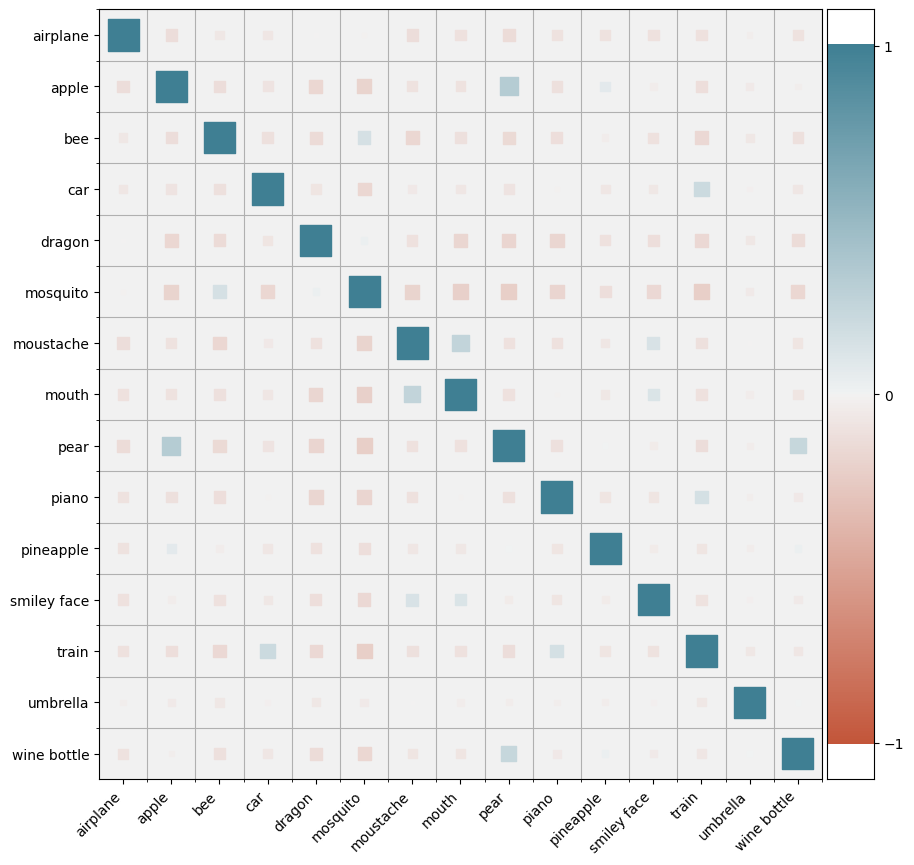

In [185]:
plt.figure(figsize=(10, 10))
corrplot(dfx[dataset.classes][dfx.pred_prob_for_true_class < 0.8].corr())